# Import

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# 创建数据集

In [2]:
words = open("../data/names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
chars = sorted(set("".join(words)))
stoi = { s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = { i: s for s, i in stoi.items() }
vocab_size = len(itos)

In [4]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")
    return X, Y

import random
random.seed(11)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size = 3
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

X.shape: torch.Size([182306, 3]), Y.shape: torch.Size([182306])
X.shape: torch.Size([22885, 3]), Y.shape: torch.Size([22885])
X.shape: torch.Size([22955, 3]), Y.shape: torch.Size([22955])


# 初始化模型参数

In [5]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(11)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"模型参数量: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

模型参数量: 11897


# 寻找合适的学习率

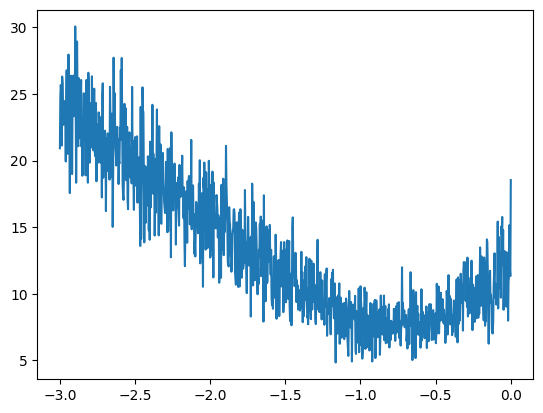

In [6]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lossi = []

batch_size = 32

for i, lr in enumerate(lrs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb] # (32, 3, 2)
    h = (emb.view((-1, n_embd * block_size)) @ W1 + b1).tanh()  # (32, h_dim)
    logits = h @ W2 + b2 # (32, vocab_dim)
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdims=True)
    # loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Yb)
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += - lr * p.grad

    lri.append(lre[i])
    lossi.append(loss.item())

plt.plot(lri, lossi)

# 训练

In [7]:
max_steps = 500000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb] # (32, 3, 2)
    h = (emb.view((-1, n_embd * block_size)) @ W1 + b1).tanh()  # (32, h_dim)
    logits = h @ W2 + b2 # (32, vocab_dim)
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdims=True)
    # loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 ** (i / max_steps * 3 + 1)
    for p in parameters:
        p.data -= 0.1 * p.grad

    # track
    if i % 10000 == 0:
        print(f"{i}/{max_steps}: {loss.item()}")
    lossi.append(loss.item())

0/500000: 14.38178825378418
10000/500000: 2.4706904888153076
20000/500000: 2.6175360679626465
30000/500000: 2.2382800579071045
40000/500000: 2.0594561100006104
50000/500000: 2.3306047916412354
60000/500000: 2.7490789890289307
70000/500000: 1.9278249740600586
80000/500000: 2.3390188217163086
90000/500000: 2.3909199237823486
100000/500000: 1.9669283628463745
110000/500000: 2.266864776611328
120000/500000: 2.4793176651000977
130000/500000: 2.1870436668395996
140000/500000: 2.3050570487976074
150000/500000: 2.2506003379821777
160000/500000: 1.9731695652008057
170000/500000: 2.1344571113586426
180000/500000: 2.1325042247772217
190000/500000: 2.322782278060913
200000/500000: 1.8524256944656372
210000/500000: 2.645937919616699
220000/500000: 2.418895721435547
230000/500000: 2.2626407146453857
240000/500000: 2.450861692428589
250000/500000: 1.8416409492492676
260000/500000: 2.20289945602417
270000/500000: 1.828460693359375
280000/500000: 2.293170213699341
290000/500000: 2.360686779022217
30000

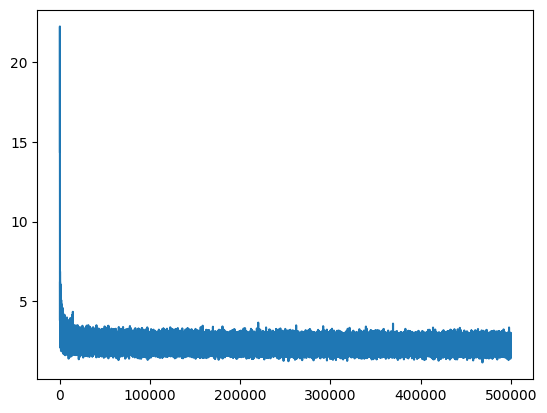

In [8]:
plt.plot(range(len(lossi)), lossi)

# 训练效果

In [9]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]
    h = (emb.view((-1, n_embd * block_size)) @ W1 + b1).tanh()  # (32, h_dim)
    logits = h @ W2 + b2 # (32, vocab_dim)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("val")
split_loss("test")

train loss: 2.1811609268188477
val loss: 2.2588727474212646
test loss: 2.269009590148926


# Embedding可视化

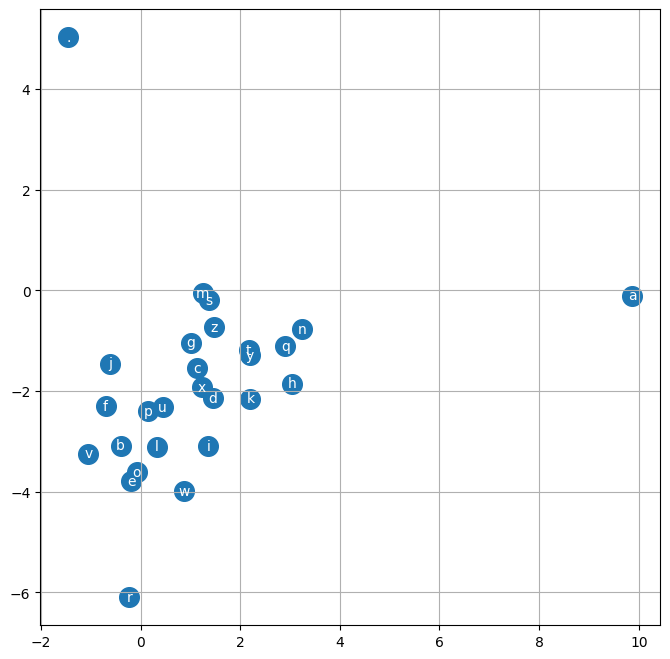

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

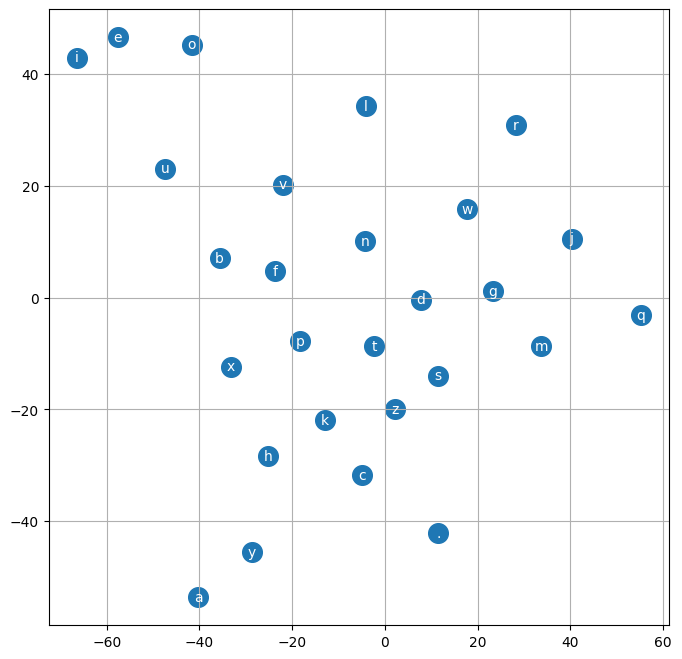

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=10)
tsne_emb = tsne.fit_transform(C.data.numpy())

plt.figure(figsize=(8, 8))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=200)
for i in range(tsne_emb.shape[0]):
    plt.text(tsne_emb[i, 0], tsne_emb[i, 1], itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# 使用模型生成名字

In [12]:
sample_size = 20

g = torch.Generator().manual_seed(11 + 10)

for _ in range(sample_size):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = (emb.view(-1, n_embd * block_size) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print("".join([itos[i] for i in out]))

tipoli
lucier
karie
karian
adin
maya
dena
inna
jrey
aaelik
avaazija
makijania
giangira
iyanna
ben
ice
valika
kio
lee
lena
